In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
from IPS_surrogate import QWR029
from cav_info import cav_info

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

# domain info

In [4]:
cav_type_name = 'QWR029'
beam_frequency = 80.5e6
cavity_frequency = 322000000 # for QWR029

In [5]:
cav_length = cav_info[cav_type_name]['cav_length']
W_u_range  =  cav_info[cav_type_name]['W_u_range']
field_amplitude_range = cav_info[cav_type_name]['field_amplitude_range']
qA_range = cav_info[cav_type_name]['qA_range']

# API

In [6]:
print(QWR029.__call__.__doc__)

None


In [7]:
# kinetic energy to relativisitc beta
def Wu2beta(w_u):  
    gamma = 1.+w_u/931.5e6
    return np.sqrt(1.0 - 1.0 / gamma ** 2)

In [8]:
def track_in_cav(
    particle_tau, cavity_phase, cavity_offset,   # input phase info
    particle_W, particle_A, particle_Q,          # input beam Wu and q/A
    cavity_field_amplitude, cavity_scale=1.0,    # input cavity strength info
    beam_frequency=beam_frequency, 
    cavity_frequency=cavity_frequency, 
    cav_length=cav_length, 
    
):
    # prepare NN model inputs (phase,Wu,cav_amp,qA)
    phase = cavity_frequency / beam_frequency * particle_tau + cavity_phase + cavity_offset
    cav_amp = cavity_field_amplitude*cavity_scale 
    Wu = particle_W/particle_A
    
    # call NN model
    dTau, dWu = QWR029(phase,Wu,cav_amp,particle_Q/particle_A)
    
    # update particle
    particle_W = particle_W + dWu*particle_A
    particle_tau = particle_tau + 2*np.pi*cav_length / (Wu2beta(Wu)*beam_frequency) + dTau
    
    return particle_tau, particle_W

# test

In [9]:
def get_random_input_sample():
    w_u,amplitude,qA,A = np.random.rand(4)
    w_u = w_u*(W_u_range[1]-W_u_range[0]) + W_u_range[0]
    amplitude *= field_amplitude_range[1]
    qA = qA*(qA_range[1]-qA_range[0]) + qA_range[0]
    A = np.random.randint(0,200) + 16
    Q = int(qA*A)
    return w_u,amplitude,A,Q

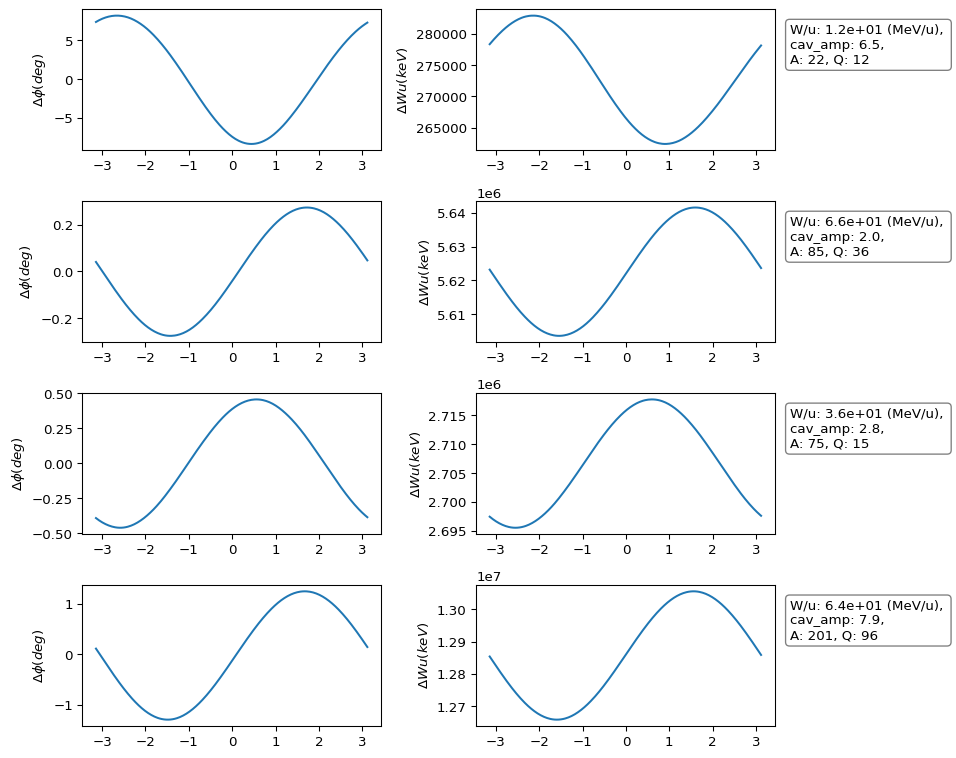

In [10]:
phase_scan = np.arange(256)/256*2*np.pi-np.pi
harm = cavity_frequency/beam_frequency

nrow = 4
fig,ax = plt.subplots(nrow,2,figsize=(10,2*nrow),dpi=96)

for irow in range(nrow):
    w_u,cav_amp,A,Q = get_random_input_sample()
    NN_dTau = np.zeros(256)
    NN_dWu  = np.zeros(256)
    for j,phase in enumerate(phase_scan):
        NN_dTau [j], NN_dWu [j] = track_in_cav(
                                        particle_tau=0, 
                                        cavity_phase=phase, 
                                        cavity_offset=0,   
                                        particle_W=w_u*A,
                                        particle_A=A, 
                                        particle_Q=Q,         
                                        cavity_field_amplitude=cav_amp)
        
    ax[irow,0].plot(phase_scan,NN_dTau *harm/np.pi*180);
    ax[irow,0].set_ylabel('$\Delta \phi (deg)$');
    ax[irow,1].plot(phase_scan,NN_dWu *1e-3);
    ax[irow,1].text(1.05,0.9,
                    f"W/u: {f'{w_u*1e-6:.2}'} (MeV/u), \ncav_amp: {f'{cav_amp:.2}'}, \nA: {A}, Q: {Q}",
                    transform=ax[irow,1].transAxes,
                    va='top', ha='left',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
                   );
    ax[irow,1].set_ylabel('$\Delta Wu (keV)$');
    
fig.tight_layout()